In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import gzip

In [4]:
reviews = [] #fetching 1st 15 lac entries from reviews file
with gzip.open('/content/drive/MyDrive/reviews.clean.json.gz') as f:
    head = [next(f) for x in range(1500000)]
    for l in head:
        reviews.append(eval(l))

In [5]:
places = [] #fetching 1st 15 lac entries from places file

with gzip.open('/content/drive/MyDrive/places.clean.json.gz') as f:
  head = [next(f) for x in range(1500000)]
  for l in head:
    places.append(eval(l))

In [6]:
data_reviews_df=pd.DataFrame() #creating data frame of the reviews file attributes
data_places_df=pd.DataFrame() #creating data frame of the places file attributes

data_reviews_df['user_id']=[x['gPlusUserId'] for x in reviews]
data_reviews_df['place_id']=[x['gPlusPlaceId'] for x in reviews]
data_reviews_df['ratings']=[x['rating'] for x in reviews]


data_places_df['place_name']=[x['name'] for x in places]
data_places_df['address']=[x['address'] for x in places]
data_places_df['gps']=[x['gps'] for x in places]
data_places_df['place_id']=[x['gPlusPlaceId'] for x in places]

In [7]:
final_data=data_reviews_df.merge(data_places_df, on='place_id', how='inner') #final data is prepared by merging both data frames on place id

print(final_data.head(5))
print(final_data.shape) #dataframe has 721599 rows and 6 columns

                 user_id               place_id  ratings          place_name  \
0  100000013500285534661  102194128241608748649      5.0   Selale Restaurant   
1  100000021336848867366  101409858828175402384      5.0  Sakana no Hokushin   
2  100000021336848867366  107443380765688783479      5.0           八木山ベニーランド   
3  100050791909819923240  107443380765688783479      4.0           八木山ベニーランド   
4  101413910070163733438  107443380765688783479      4.0           八木山ベニーランド   

                                             address                      gps  
0  [Pınarkent Bld. Atatürk Cd. Pk:20145 Denizli M...       [37.8037, 29.2209]  
1  [1 Chome-4-1 Izumichuo, Izumi Ward, Sendai, Mi...  [38.323455, 140.882111]  
2  [Japan, 〒982-0837 Miyagi, Sendai, Taihaku Ward...   [38.24675, 140.848436]  
3  [Japan, 〒982-0837 Miyagi, Sendai, Taihaku Ward...   [38.24675, 140.848436]  
4  [Japan, 〒982-0837 Miyagi, Sendai, Taihaku Ward...   [38.24675, 140.848436]  
(721599, 6)


In [8]:
print(len(final_data['place_id'].unique())) #these are the unique places in the final data
print(len(final_data['user_id'].unique()))  #these are the unique users in the final data

465757
386978


In [10]:
#generating items

places_to_ratings_df=pd.DataFrame()
places_to_ratings_df['place_id']=final_data['place_id']
places_to_ratings_df['ratings']=final_data['ratings']

users_to_ratings_df=pd.DataFrame()
users_to_ratings_df['user_id']=final_data['user_id']
users_to_ratings_df['ratings']=final_data['ratings']

count_ratings_users=pd.DataFrame(users_to_ratings_df.groupby('user_id',as_index=False).count())
count_ratings_users=count_ratings_users.sort_values(by='ratings',ascending=False)
count_ratings_users.rename(columns = {'ratings':'Count'}, inplace = True)
count_ratings_users=count_ratings_users[count_ratings_users['Count']>=10]

df0=count_ratings_users.merge(final_data,on='user_id',how='inner')

count_ratings_places=pd.DataFrame(places_to_ratings_df.groupby('place_id',as_index=False).count())
count_ratings_places=count_ratings_places.sort_values(by='ratings',ascending=False)
count_ratings_places.rename(columns = {'ratings':'Count'}, inplace = True)
count_ratings_places=count_ratings_places[count_ratings_places['Count']>=10]
df1=count_ratings_places.merge(df0,on='place_id', how='inner') #I am creating a new dataframe by keeping only those users who have rated at least 10 places and keeping only those 
#places which have been rated at least by 10 users

In [11]:
df2=df1.drop(['Count_x','Count_y','ratings','user_id'],axis=1) #this dataframe I am creating to call only unique place id,place name, address and gps 
df2=df2.drop_duplicates(subset='place_id')

In [ ]:
#Exploratory Data Analysis
#Through Plots and Tables, I would answer:
#Top places that the users have visited
#How many distinct users are there and how many times they have rated
#How many distinct places are there and how many times they have been rated
#Distribution of the Ratings

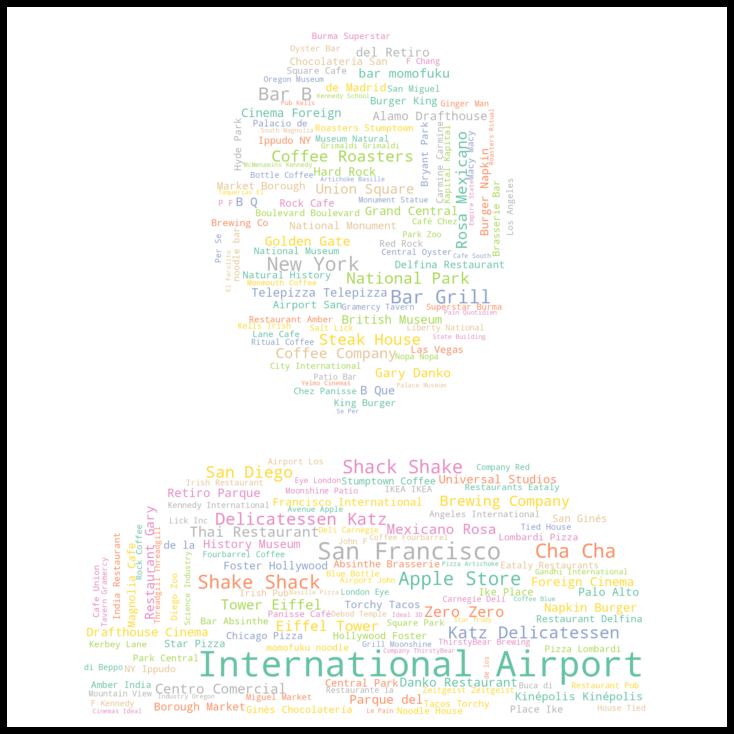

In [15]:
#Top Places that users have visited through Word Cloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image
import numpy as np

stopwords = set(STOPWORDS)
mask = np.array(Image.open('/content/user.png'))

#we will read the text
data=df1['place_name']
#wordcloud
wordcloud = WordCloud(stopwords = stopwords , width=1000 , height=500,mask=mask,background_color="White",colormap="Set2").generate('   '.join(data))
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout (pad=0)

In [39]:
#Distinct Users and How many times they have rated (Top 15)
df3=df1.drop(['Count_x','ratings','place_id'],axis=1)
df3=df3.drop_duplicates(subset='user_id')
#Plotting top 50 users and frequency of ratings
top_15_users=pd.DataFrame()
top_15_users['user_id']=df3['user_id'][:15]
top_15_users['count']=df3['Count_y'][:15]

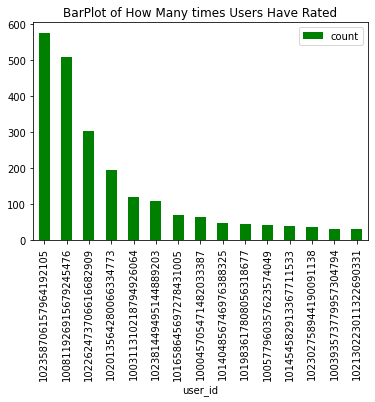

In [40]:
top_15_users.plot(kind = 'bar',x = 'user_id',y = 'count',color = 'green')
plt.title('BarPlot of How Many times Users Have Rated')
plt.show()

In [42]:
#Distinct Places and how many times they have been rated (Top 15)
df4=df1.drop(['Count_y','ratings','user_id'],axis=1)
df4=df4.drop_duplicates(subset='place_id')
top_15_places=pd.DataFrame()
top_15_places['place_name']=df4['place_name'][:15]
top_15_places['count']=df4['Count_x'][:15]

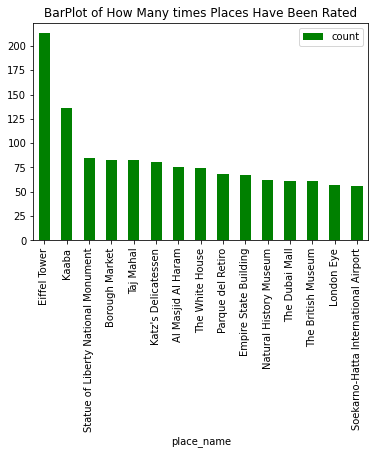

In [43]:
top_15_places.plot(kind = 'bar',x = 'place_name',y = 'count',color = 'green')
plt.title('BarPlot of How Many times Places Have Been Rated')
plt.show()

In [45]:
#Distribution of the Ratings
df5=df1.drop(['Count_x','Count_y'],axis=1)
df5.describe()  
#We can see mean ratings is 4.09 and 25% and above --ratings are >4 

,ratings
count,11453.000000
mean,4.094298
std,0.912815
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000
